Notebook purpose

- Explore whether users groceryshop more frequently spend more on groceries to see whether there might be a way to link this to narrow bracketing.

Finding and decision:

- There is a strong correlation between number of grocery shops and spending on groceries both at the weekly and monthly level.

- Given the data, we cannot differentiate between cases where a higher need for groceries (e.g. having guests over, having children) led to more shopping trips from those cases where more grocery trips let to higher spend (because one higher exposure to tempting stuff one doesn't actually need). We'd need to control for 'need', which we have no way of knowing.

- Won't pursue this any further.

In [43]:
import os
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [3]:
dfs, dfl = hd.read_samples(["777", "XX7"])
hd.inspect(dfl)

(16,074,957, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209


## Grocery shopping

### Monthly

In [79]:
def grocery_spend(df, freq="m"):
    df = df.set_index(["user_id", "date"]).copy()
    freq = pd.Grouper(level="date", freq=freq)
    mask = df.tag_auto.str.contains("groceries", na=False)
    groceries_spend = df.amount.where(mask, np.nan)
    return groceries_spend.groupby(["user_id", freq]).agg(
        [("spend", "sum"), ("txns", "count")]
    )


def trim_outliers(df):
    df["spend"] = hd.trim(df.spend, pct=1, how="both")
    df["txns"] = hd.trim(df.txns, pct=1, how="upper")
    return df.dropna()

In [80]:
df = grocery_spend(dfl, freq="m").pipe(trim_outliers)
hd.inspect(df)

(160,722, 2)


spend  txns
user_id date                        
57      2012-04-30  132.630005  19.0
        2012-05-31  155.150009  18.0

In [76]:
df.describe()

,spend,txns
count,160722.000000,160722.000000
mean,248.651810,13.729894
std,229.679611,10.401931
min,0.000000,0.000000
25%,76.812498,6.000000
50%,182.710007,12.000000
75%,354.200005,20.000000
max,1206.339966,53.000000


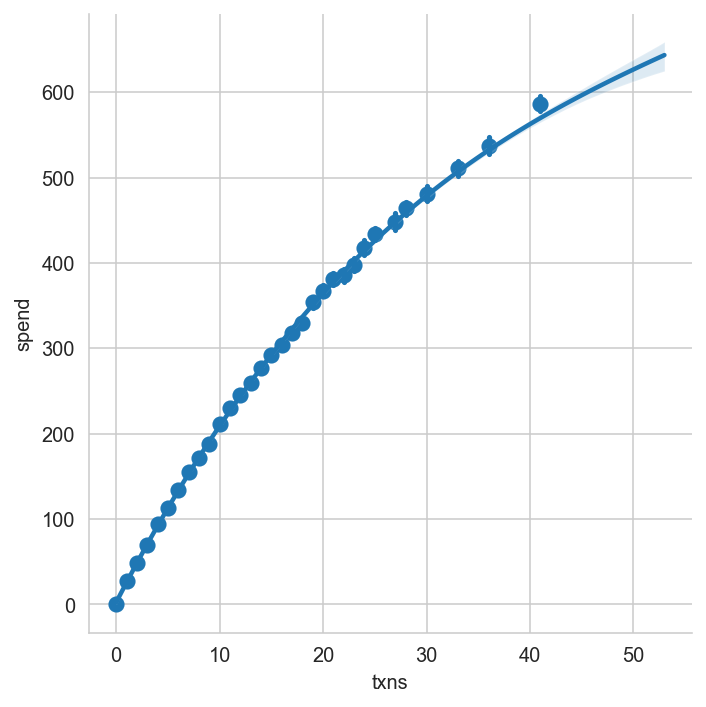

In [40]:
sns.lmplot(data=df, x="txns", y="spend", x_bins=50, order=3)

In [64]:
a = lm.PanelOLS.from_formula("spend ~ 1 + txns", data=df).fit()
b = lm.PanelOLS.from_formula("spend ~ 1 + txns + EntityEffects", data=df).fit()
c = lm.PanelOLS.from_formula("spend ~ 1 + txns + TimeEffects", data=df).fit()
d = lm.PanelOLS.from_formula(
    "spend ~ 1 + txns + EntityEffects + TimeEffects", data=df
).fit()
e = lm.PanelOLS.from_formula(
    "spend ~ 1 + txns + EntityEffects + TimeEffects", data=df
).fit(cov_type="clustered", cluster_entity=True)

In [65]:
lm.panel.compare([a, b, c, d, e], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4
Dep. Variable,spend,spend,spend,spend,spend
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,160722,160722,160722,160722,160722
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,0.4296,0.4384,0.4356,0.4469,0.4469
R-Squared (Within),0.4360,0.4384,0.4353,0.4383,0.4383
R-Squared (Between),0.4367,0.4329,0.4370,0.4338,0.4338
R-Squared (Overall),0.4296,0.4276,0.4295,0.4282,0.4282
F-statistic,1.21e+05,1.21e+05,1.239e+05,1.252e+05,1.252e+05
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000


### Weekly

In [81]:
df = grocery_spend(dfl, freq="w").pipe(trim_outliers)
hd.inspect(df)

(698,583, 2)


spend  txns
user_id date                       
57      2012-04-08  45.709999   4.0
        2012-04-15  30.120001   6.0

In [82]:
df.describe()

,spend,txns
count,698583.000000,698583.000000
mean,55.635056,3.112894
std,62.868896,2.808717
min,0.000000,0.000000
25%,5.830000,1.000000
50%,34.810001,3.000000
75%,83.250000,5.000000
max,335.640015,13.000000


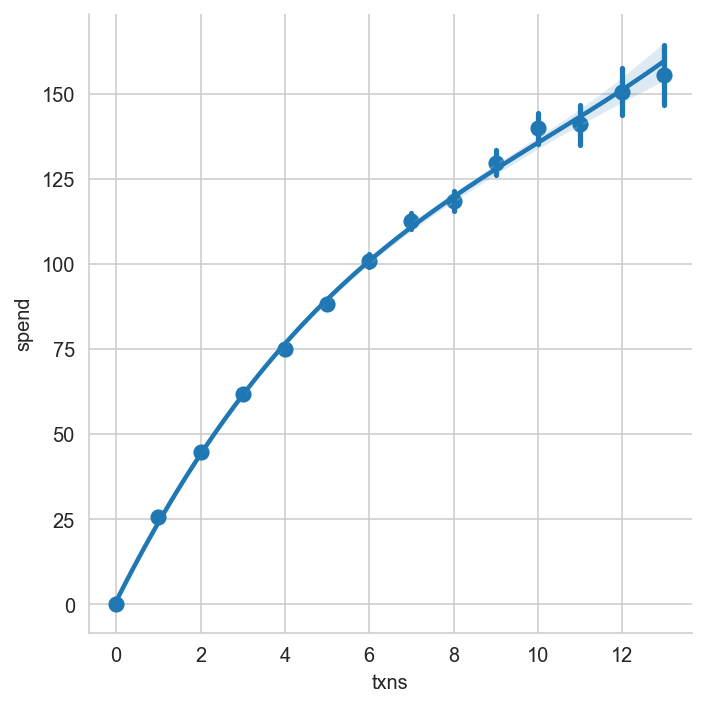

In [94]:
sample = df.sample(frac=0.1)
bins = range(int(max(sample.txns) + 1))
sns.lmplot(data=sample, x="txns", y="spend", x_bins=bins, order=3)

In [95]:
a = lm.PanelOLS.from_formula("spend ~ 1 + txns", data=df).fit()
b = lm.PanelOLS.from_formula("spend ~ 1 + txns + EntityEffects", data=df).fit()
c = lm.PanelOLS.from_formula("spend ~ 1 + txns + TimeEffects", data=df).fit()
d = lm.PanelOLS.from_formula(
    "spend ~ 1 + txns + EntityEffects + TimeEffects", data=df
).fit()
e = lm.PanelOLS.from_formula(
    "spend ~ 1 + txns + EntityEffects + TimeEffects", data=df
).fit(cov_type="clustered", cluster_entity=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/model.py:1491: MemoryWarning: Using low-memory algorithm to estimate two-way model. Explicitly set low_memory=True to silence this message.  Set low_memory=False to use the standard algorithm that creates dummy variables for the smaller of the number of entities or number of time periods.
  warnings.warn(


In [96]:
lm.panel.compare([a, b, c, d, e], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4
Dep. Variable,spend,spend,spend,spend,spend
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,698583,698583,698583,698583,698583
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,0.4036,0.3789,0.4085,0.3835,0.3835
R-Squared (Within),0.3778,0.3789,0.3774,0.3788,0.3788
R-Squared (Between),0.4481,0.4448,0.4484,0.4456,0.4456
R-Squared (Overall),0.4036,0.4026,0.4036,0.4030,0.4030
F-statistic,4.728e+05,4.226e+05,4.822e+05,4.307e+05,4.307e+05
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000
